In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, random_split


## DATA UNDERSTANDING

Load Dataset Prediksi

In [2]:
weather = pd.read_csv('C:/Users/Devina/Documents/UAS DATMIN/weather_prediction_dataset.csv') 

Cek kelengkapan feature

In [3]:
weather.columns = [col.replace("_", "").lower().strip() for col in weather.columns]

features = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure', 'globalradiation', 
    'precipitation', 'sunshine', 'tempmean', 'tempmin', 'tempmax'
]

kota_fitur = {}
for col in weather.columns:
    for feature in features:
        if col.endswith(feature):
            kota = col.replace(feature, "")
            if kota not in kota_fitur:
                kota_fitur[kota] = set()
            kota_fitur[kota].add(feature)
            break

kota_lengkap = [kota for kota, fitur_set in kota_fitur.items() if all(f in fitur_set for f in features)]

kota_tidak_lengkap = {}
for kota, fitur_set in kota_fitur.items():
    if kota not in kota_lengkap:
        fitur_kurang = [f for f in features if f not in fitur_set]
        kota_tidak_lengkap[kota] = fitur_kurang

kolom_kota_lengkap = [col for col in weather.columns if any(col.startswith(kota) for kota in kota_lengkap)]

df_kota_lengkap = weather[kolom_kota_lengkap]

print("Kota dengan fitur lengkap:")
print(kota_lengkap)

print("\nKota yang fiturnya tidak lengkap dan fitur yang hilang:")
for kota, fitur_kurang in kota_tidak_lengkap.items():
    print(f"- {kota}: kurang {fitur_kurang}")


Kota dengan fitur lengkap:
['debilt', 'dusseldorf', 'maastricht', 'muenchen', 'oslo']

Kota yang fiturnya tidak lengkap dan fitur yang hilang:
- basel: kurang ['windspeed', 'windgust']
- budapest: kurang ['windspeed', 'windgust', 'tempmin']
- dresden: kurang ['pressure']
- heathrow: kurang ['windspeed', 'windgust']
- kassel: kurang ['cloudcover']
- ljubljana: kurang ['windgust']
- malmo: kurang ['cloudcover', 'windgust', 'humidity', 'pressure', 'globalradiation', 'sunshine']
- montelimar: kurang ['cloudcover', 'windgust', 'sunshine']
- perpignan: kurang ['cloudcover', 'windgust', 'sunshine']
- roma: kurang ['windspeed', 'windgust', 'precipitation']
- sonnblick: kurang ['windspeed', 'windgust', 'pressure']
- stockholm: kurang ['windspeed', 'windgust', 'humidity', 'globalradiation']
- tours: kurang ['cloudcover', 'windgust', 'sunshine']


In [4]:
kolom_debilt = [col for col in weather.columns if col.startswith('debilt')]
weather = weather.drop(columns=kolom_debilt)

Simpan kota dengan feature yang lengkap

In [5]:
kota_lengkap = [kota for kota in kota_lengkap if kota != 'debilt']

kolom_kota_lengkap = [col for col in weather.columns if any(col.startswith(kota) for kota in kota_lengkap)]
df_kota_lengkap = weather[kolom_kota_lengkap].copy()

if 'date' in weather.columns:
    df_kota_lengkap.insert(0, 'date', weather['date'])

df_kota_lengkap.to_csv('kota_lengkap.csv', index=False)

print("\nDataset kota dengan fitur lengkap berhasil disimpan ke 'kota_lengkap.csv'")


Dataset kota dengan fitur lengkap berhasil disimpan ke 'kota_lengkap.csv'


Load data kota_lengkap

In [6]:
cuaca = pd.read_csv('C:/Users/Devina/Documents/UAS DATMIN/kota_lengkap.csv') 

Info Dataset

In [7]:
print("Info Dataset:")
print(cuaca.info())


Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       3654 non-null   int64  
 1   dusseldorfcloudcover       3654 non-null   int64  
 2   dusseldorfwindspeed        3654 non-null   float64
 3   dusseldorfwindgust         3654 non-null   float64
 4   dusseldorfhumidity         3654 non-null   float64
 5   dusseldorfpressure         3654 non-null   float64
 6   dusseldorfglobalradiation  3654 non-null   float64
 7   dusseldorfprecipitation    3654 non-null   float64
 8   dusseldorfsunshine         3654 non-null   float64
 9   dusseldorftempmean         3654 non-null   float64
 10  dusseldorftempmin          3654 non-null   float64
 11  dusseldorftempmax          3654 non-null   float64
 12  maastrichtcloudcover       3654 non-null   int64  
 13  maastrichtwindspeed        3654 no

Statistik Deskriptif

In [8]:
print("Statistik Deskriptif:")
print(cuaca.describe())

Statistik Deskriptif:
               date  dusseldorfcloudcover  dusseldorfwindspeed  \
count  3.654000e+03           3654.000000          3654.000000   
mean   2.004568e+07              5.141762             3.963738   
std    2.874287e+04              2.115639             1.718106   
min    2.000010e+07              0.000000             1.000000   
25%    2.002070e+07              4.000000             2.600000   
50%    2.004567e+07              6.000000             3.700000   
75%    2.007070e+07              7.000000             5.000000   
max    2.010010e+07              8.000000            12.200000   

       dusseldorfwindgust  dusseldorfhumidity  dusseldorfpressure  \
count         3654.000000         3654.000000         3654.000000   
mean            10.591680            0.755744            1.016000   
std              3.884296            0.111595            0.009302   
min              2.800000            0.260000            0.975900   
25%              7.800000            0

## EXPLORATORY DATA ANALYSIS

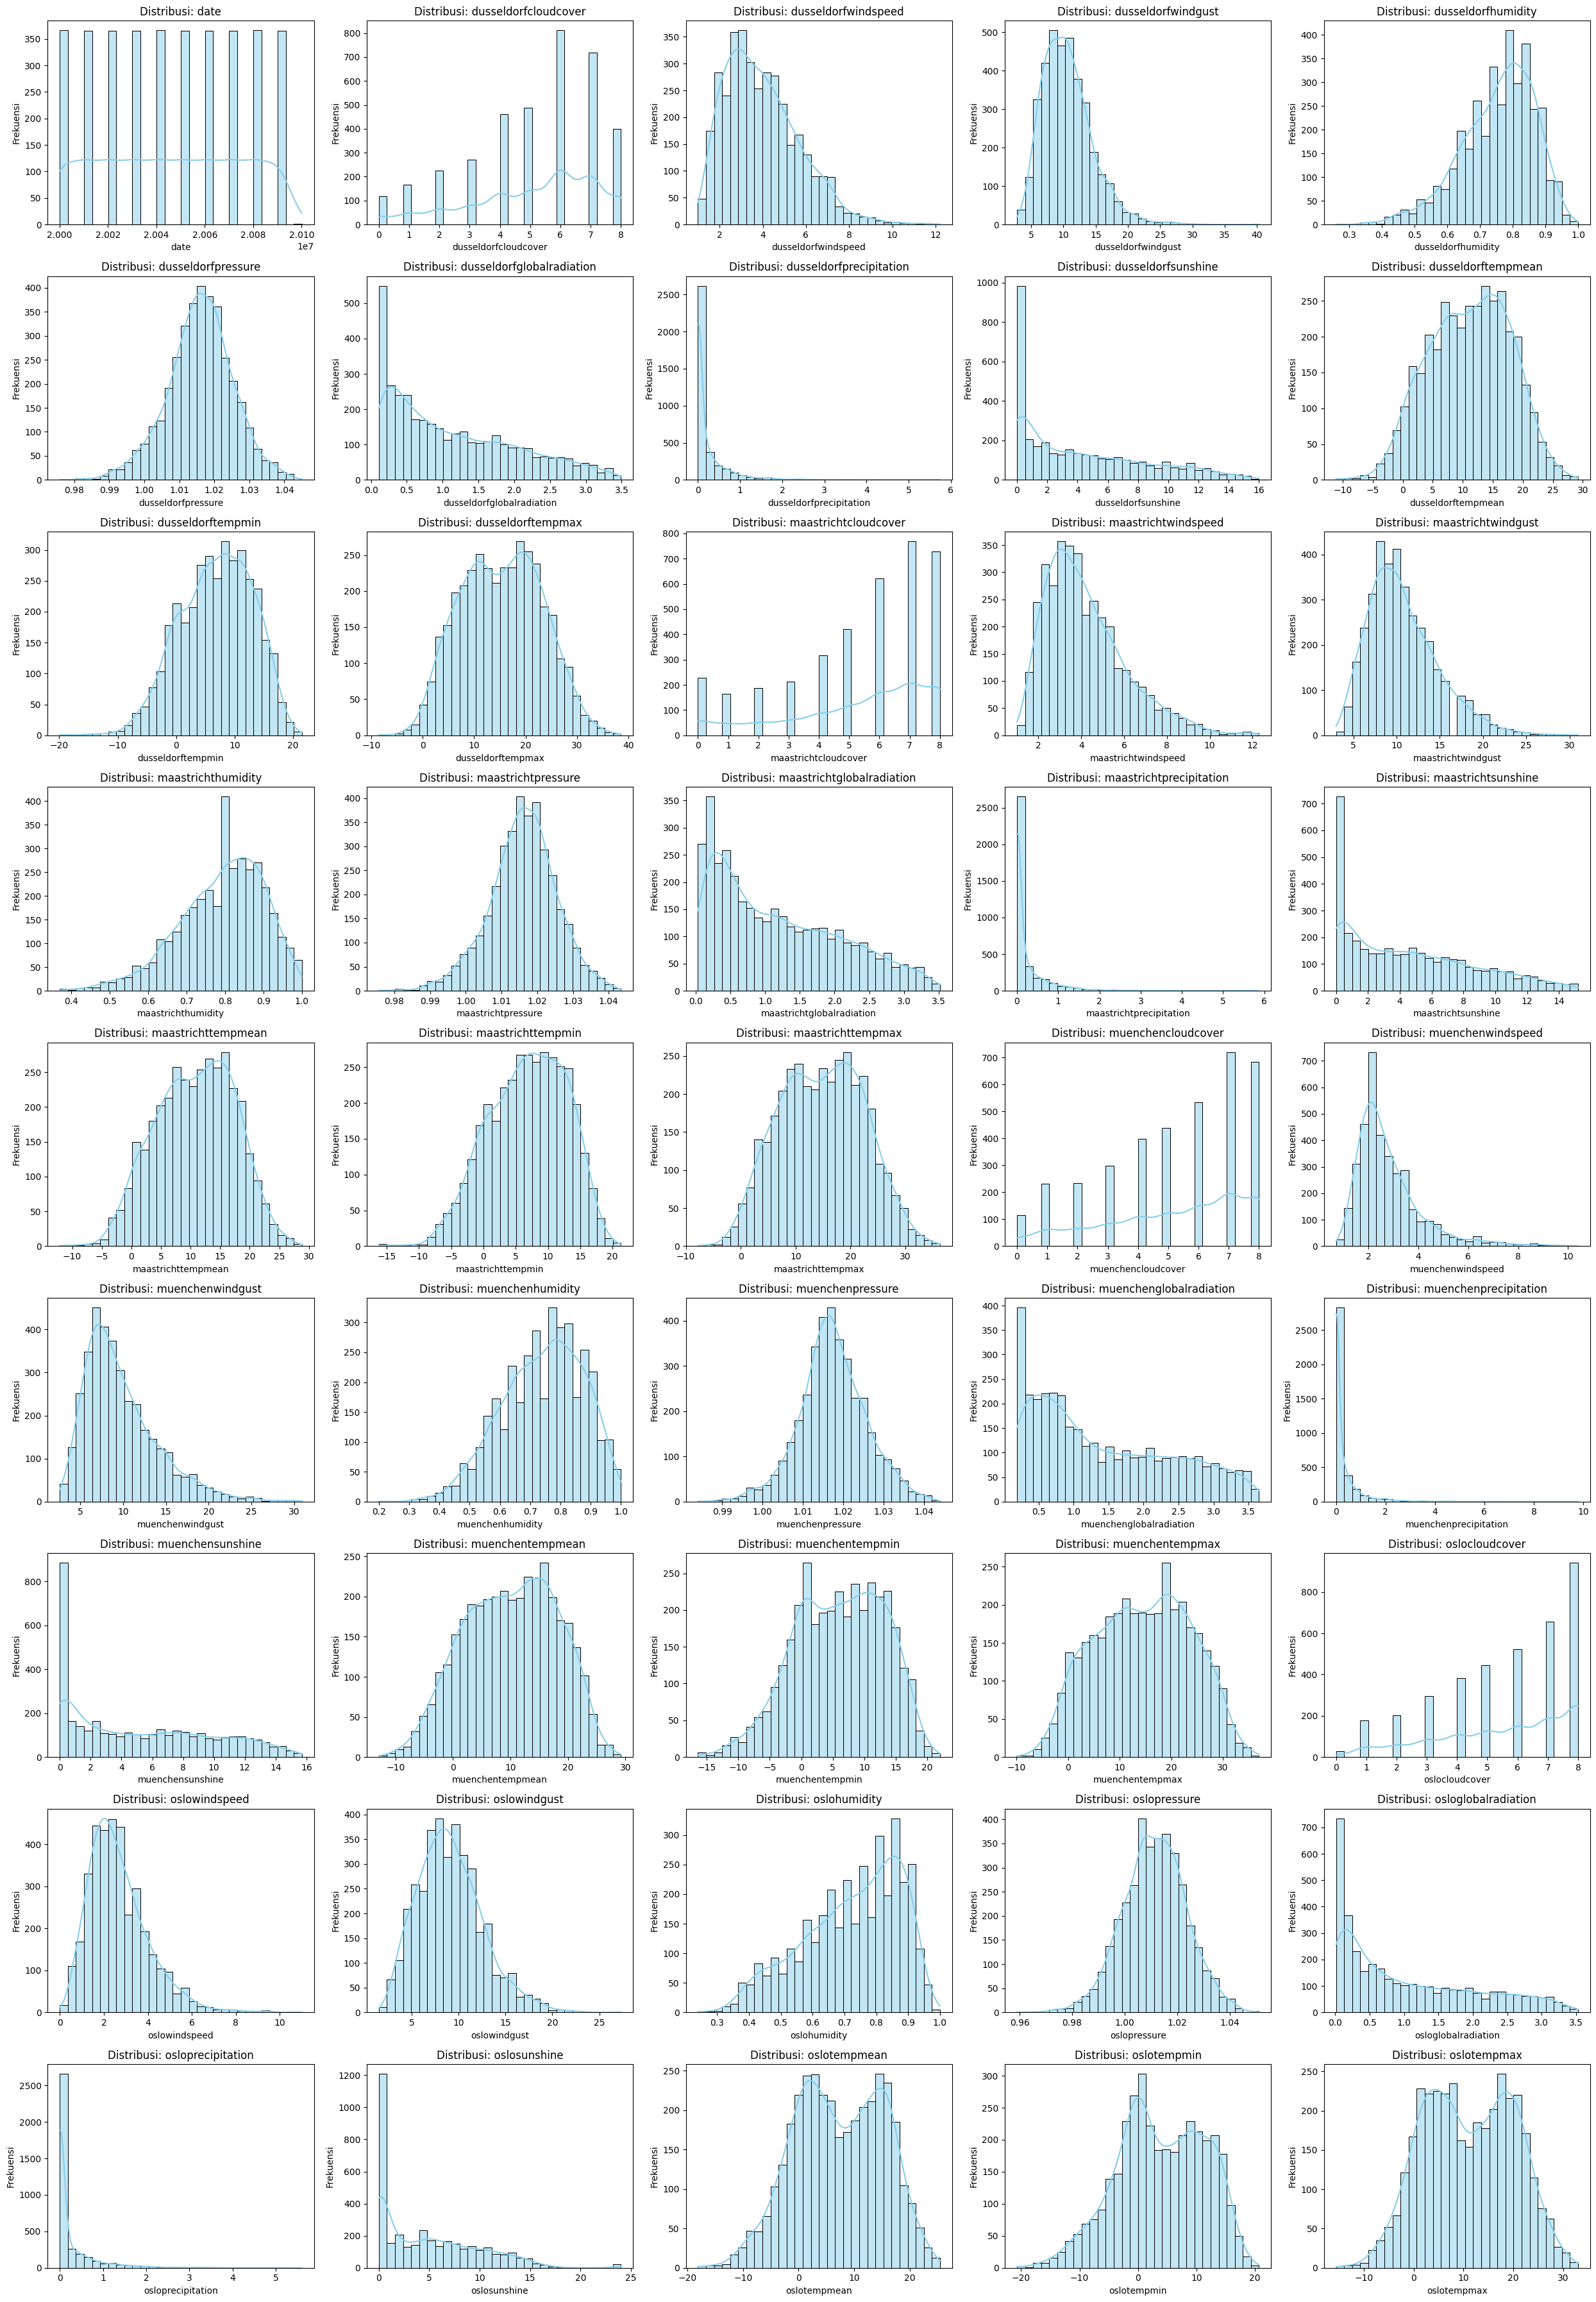

In [9]:
numerical_cols = cuaca.select_dtypes(include='number').columns
ncols = 5
nrows = math.ceil(len(numerical_cols) / ncols)
plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(cuaca[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f"Distribusi: {col}")
    plt.xlabel(col)
    plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()

Cek Missing Value


Missing Values per Kolom:
Series([], dtype: int64)


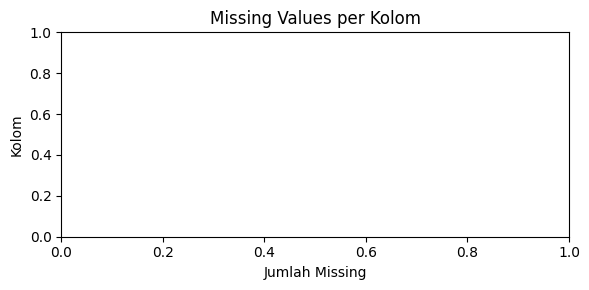

In [10]:
missing = cuaca.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("\nMissing Values per Kolom:")
print(missing)

plt.figure(figsize=(6,3))
sns.barplot(x=missing.values, y=missing.index, palette='Reds_r')
plt.title("Missing Values per Kolom")
plt.xlabel("Jumlah Missing")
plt.ylabel("Kolom")
plt.tight_layout()
plt.show()

<Figure size 1600x600 with 0 Axes>

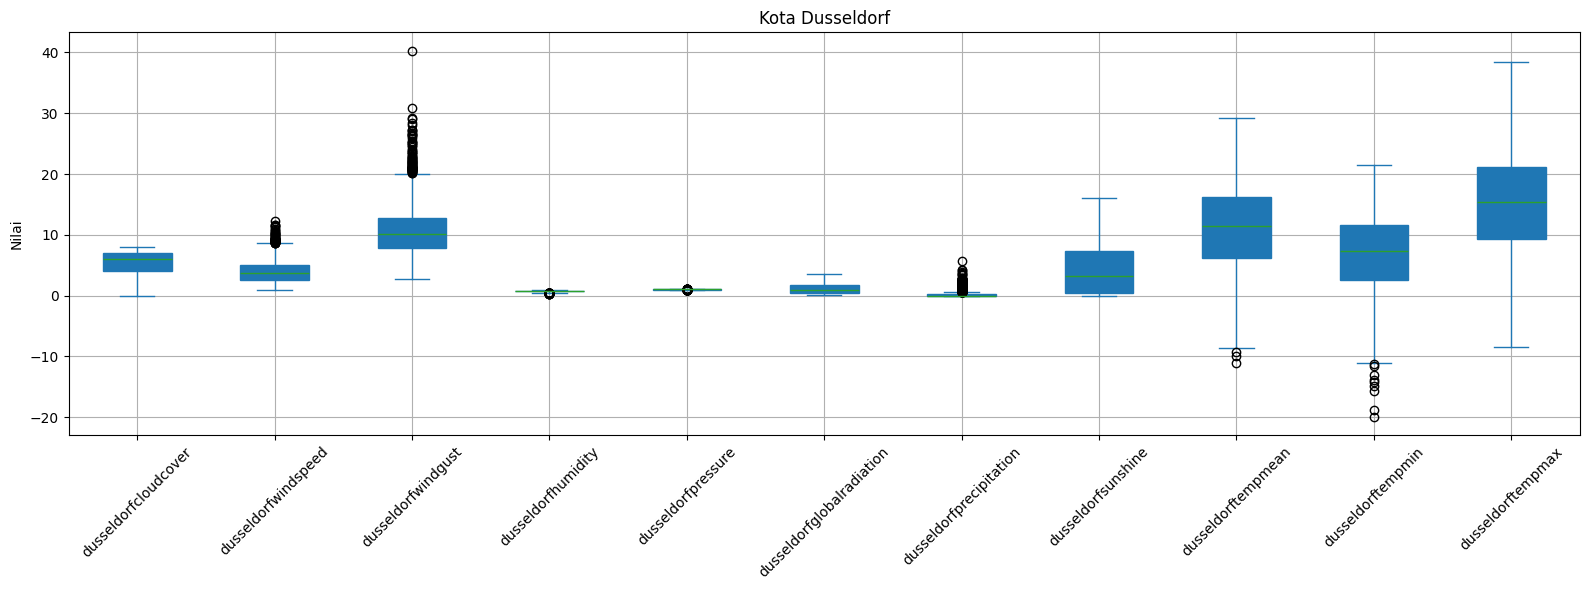

<Figure size 1600x600 with 0 Axes>

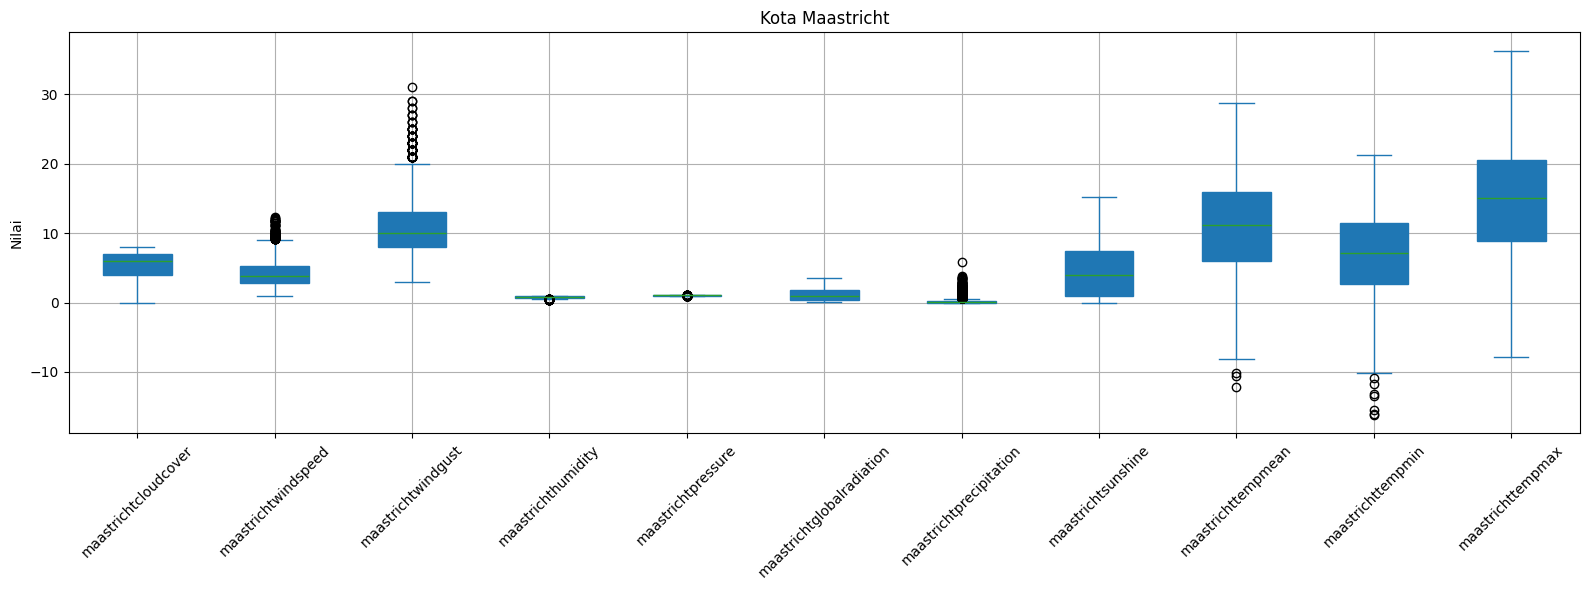

<Figure size 1600x600 with 0 Axes>

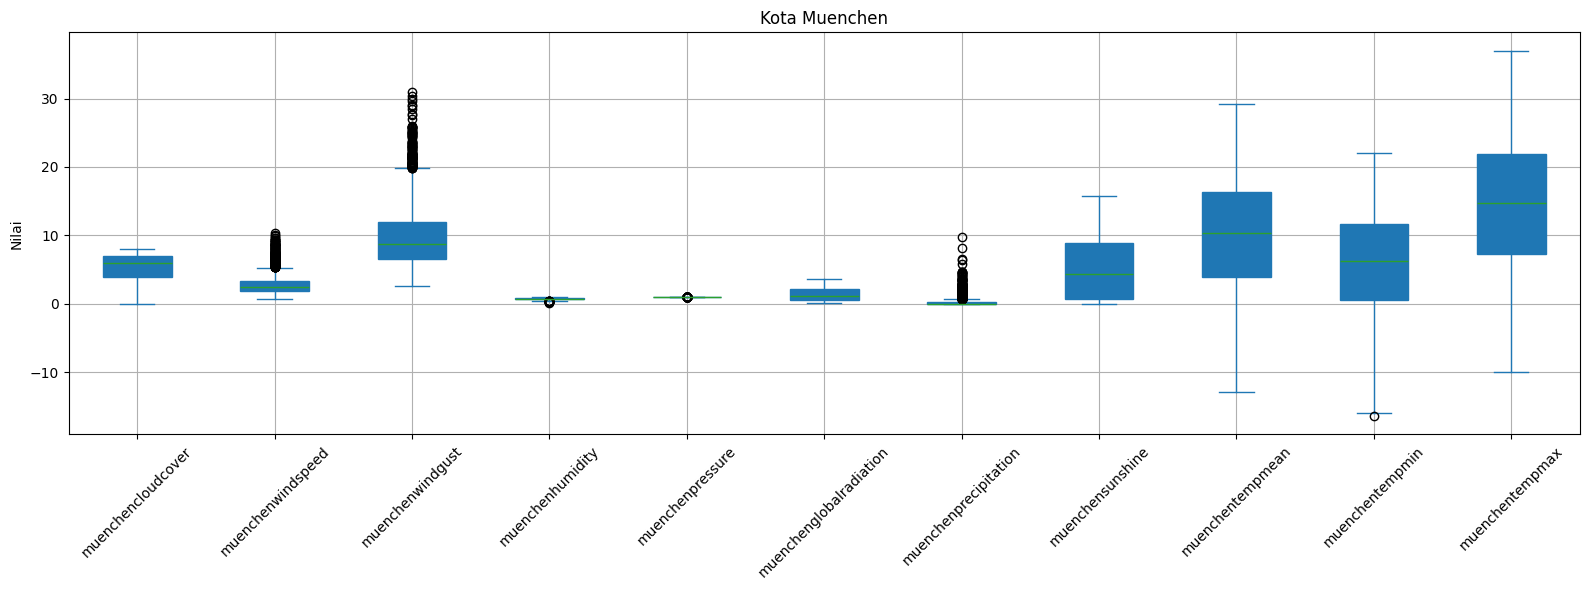

<Figure size 1600x600 with 0 Axes>

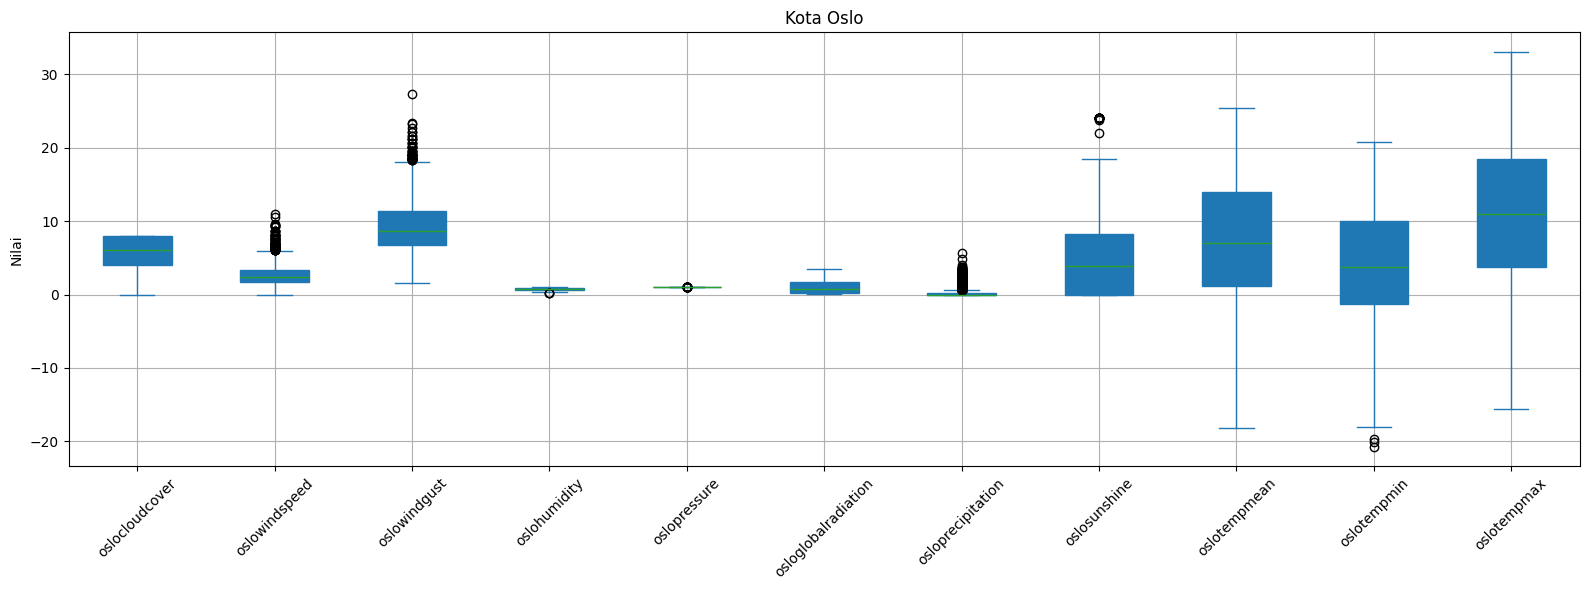

In [11]:
kota_list = ['dusseldorf', 'maastricht', 'muenchen', 'oslo']

features = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure', 'globalradiation', 
    'precipitation', 'sunshine', 'tempmean', 'tempmin', 'tempmax'
]

for kota in kota_list:
    kota_cols = [col for col in cuaca.columns if col.startswith(kota)]
    
    kota_cols = sorted(kota_cols, key=lambda x: features.index(x.replace(kota, "")) if x.replace(kota, "") in features else 99)
    
    if not kota_cols:
        continue

    plt.figure(figsize=(16, 6))
    weather[kota_cols].plot(kind='box', figsize=(16, 6), patch_artist=True)
    plt.title(f"Kota {kota.capitalize()}")
    plt.ylabel("Nilai")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

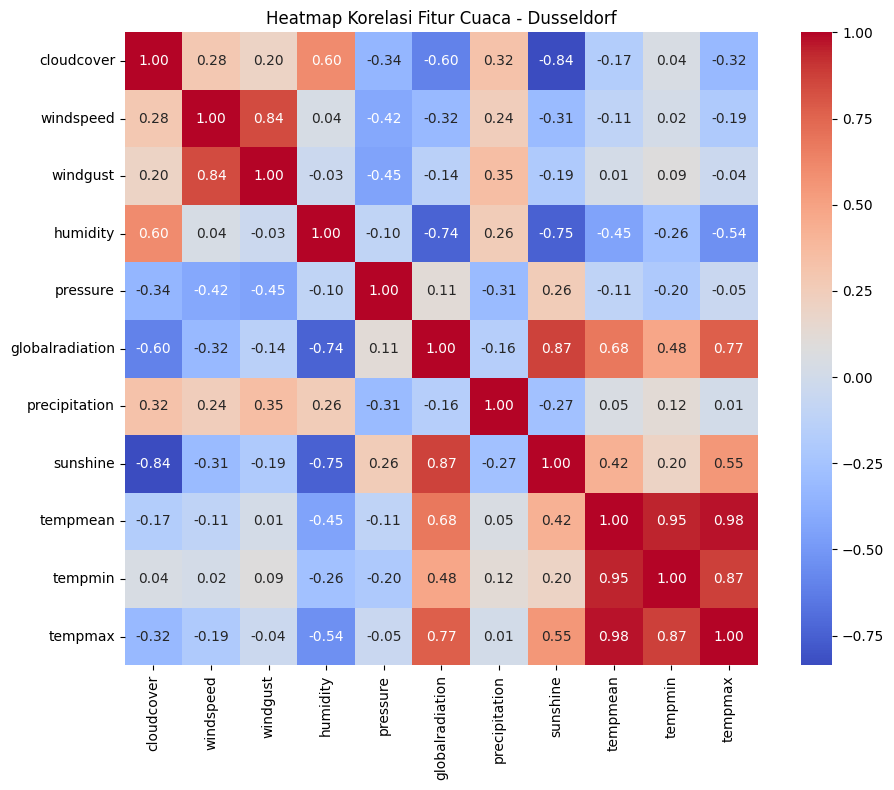

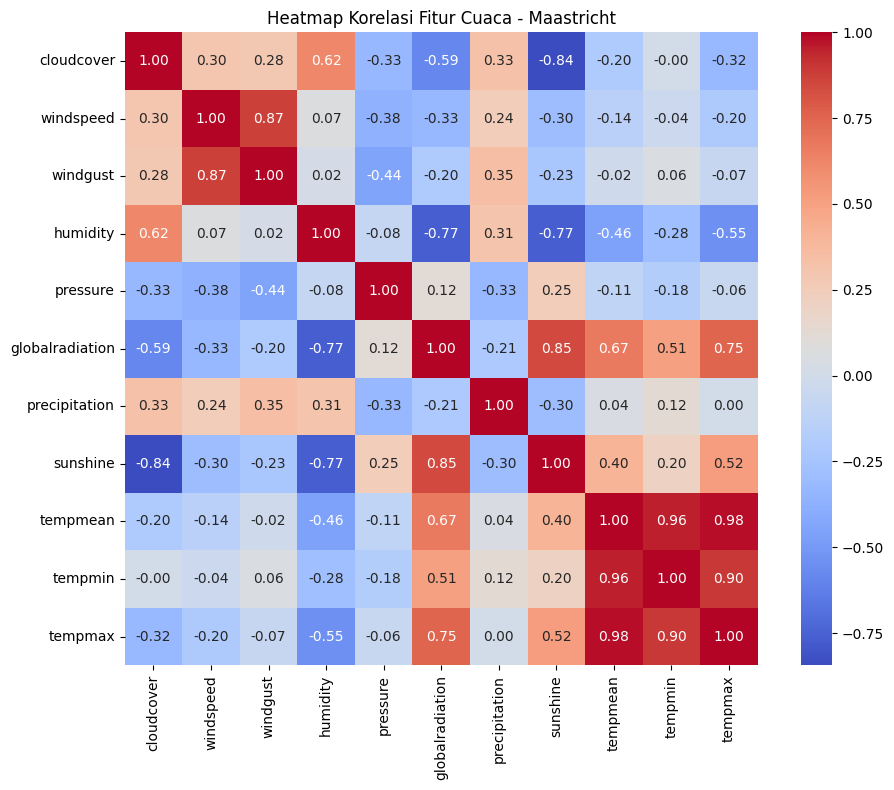

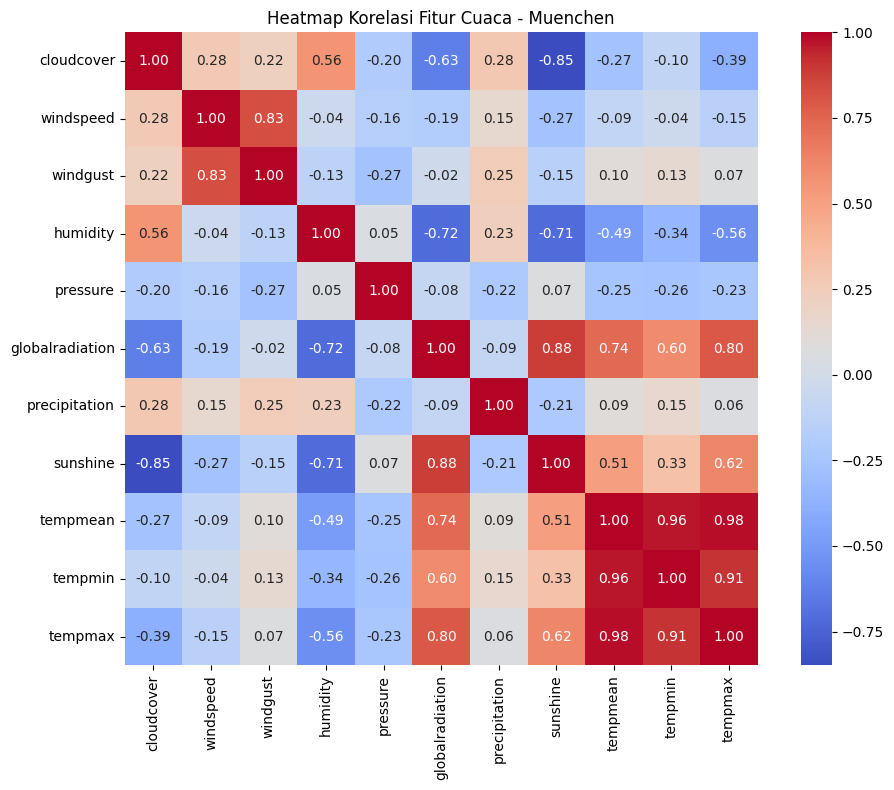

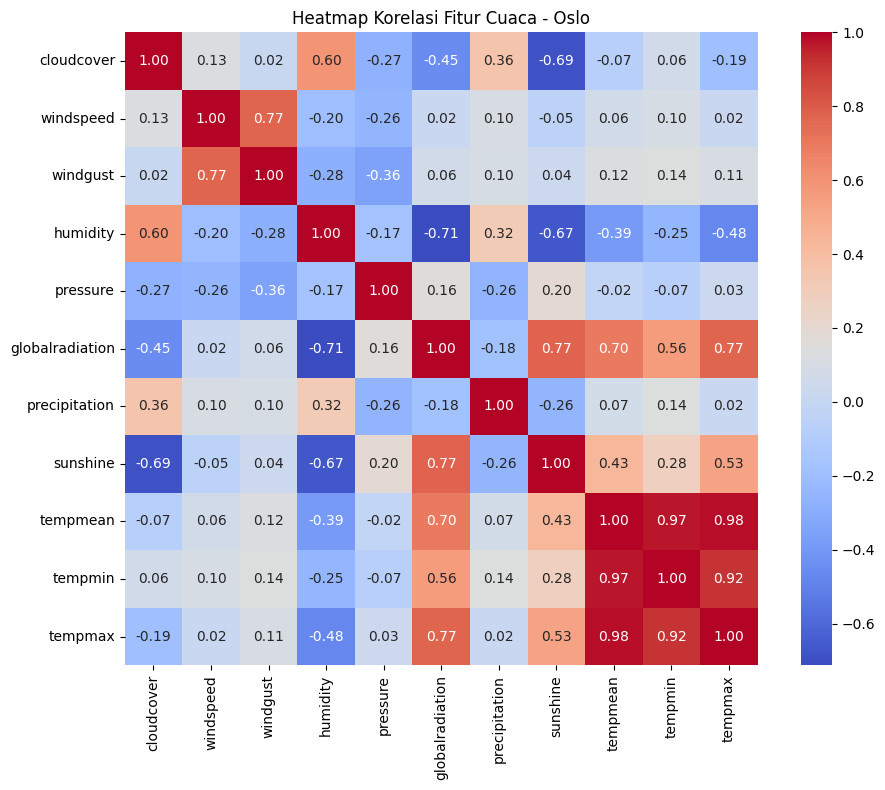

In [12]:
kolom_fitur_kota = [f"{kota}{fitur}" for fitur in features if f"{kota}{fitur}" in cuaca.columns]

for kota in kota_list:
    kota_cols = [col for col in cuaca.columns if col.startswith(kota)]
    kota_cols = sorted(
        kota_cols,
        key=lambda x: features.index(x.replace(kota, "")) if x.replace(kota, "") in features else 99
    )
    renamed_cols = {f"{kota}{feat}": feat for feat in features if f"{kota}{feat}" in kota_cols}

    if not renamed_cols:
        continue
    df_kota = cuaca[list(renamed_cols.keys())].rename(columns=renamed_cols)
    corr = df_kota.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f"Heatmap Korelasi Fitur Cuaca - {kota.capitalize()}")
    plt.tight_layout()
    plt.show()


## PRE-PROCESSING

Handling Outliers

C:\Users\Devina\AppData\Local\Temp\ipykernel_2252\2991163968.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


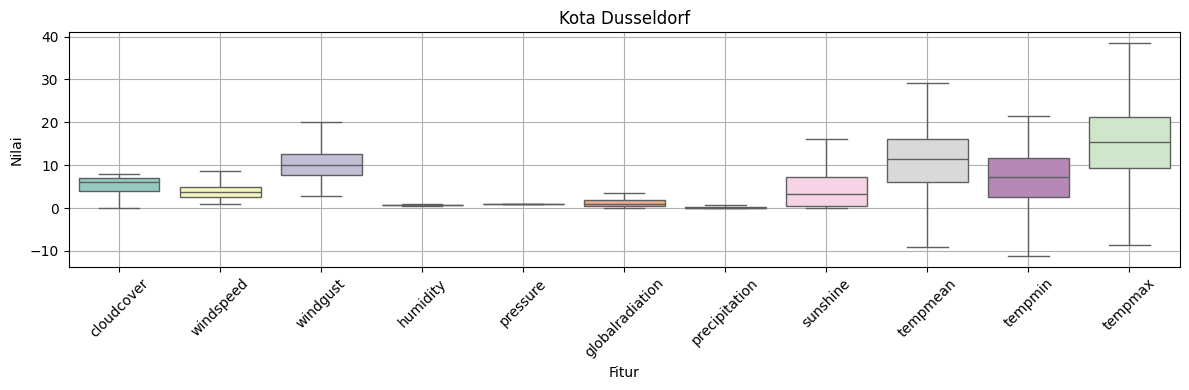

C:\Users\Devina\AppData\Local\Temp\ipykernel_2252\2991163968.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


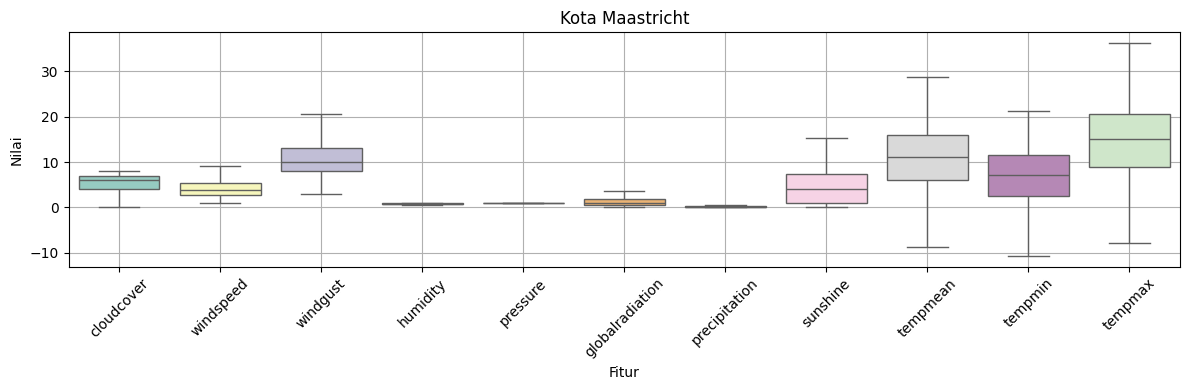

C:\Users\Devina\AppData\Local\Temp\ipykernel_2252\2991163968.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


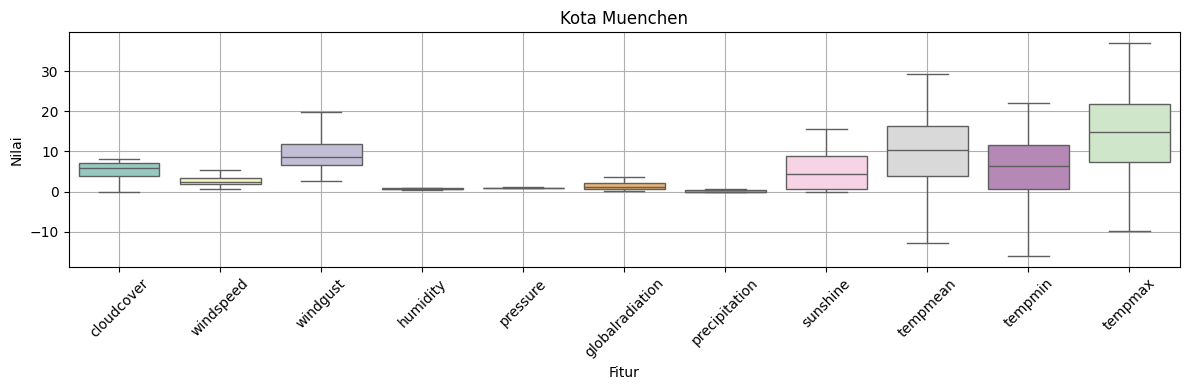

C:\Users\Devina\AppData\Local\Temp\ipykernel_2252\2991163968.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


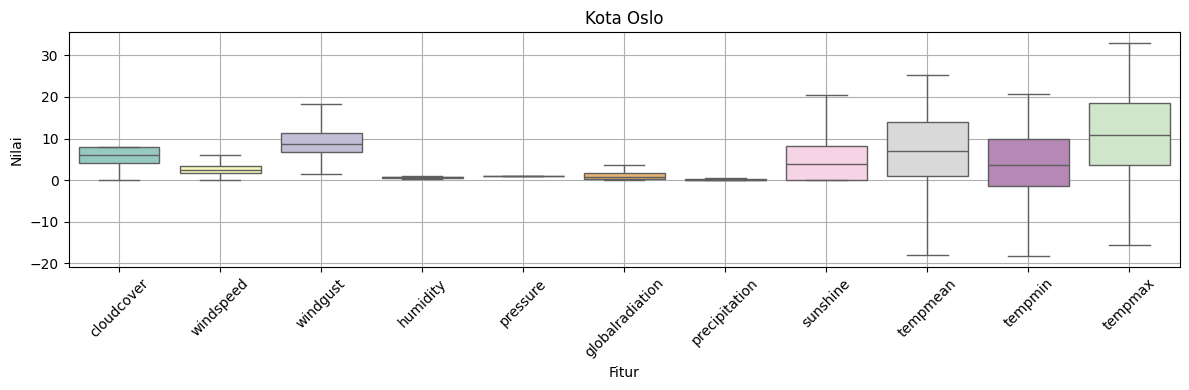

In [13]:
cuaca_outlier_handled = cuaca.copy()

def handle_outliers_column(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df[col]

for kota in kota_list:
    kota_cols = [f"{kota}{feature}" for feature in features if f"{kota}{feature}" in cuaca_outlier_handled.columns]

    for col in kota_cols:
        cuaca_outlier_handled[col] = handle_outliers_column(cuaca_outlier_handled, col)

    df_kota = cuaca_outlier_handled[kota_cols].copy()
    df_kota.columns = features  
    df_melt = df_kota.melt(var_name="Fitur", value_name="Nilai")

    plt.figure(figsize=(12, 4))
    sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")
    plt.title(f"Kota {kota.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [14]:
cuaca_outlier_handled.to_csv('C:/Users/Devina/Documents/UAS DATMIN/cuaca_bersih.csv', index=False)

## MODEL LSTM

In [15]:
cb = pd.read_csv('C:/Users/Devina/Documents/UAS DATMIN/cuaca_bersih.csv') 

In [25]:
kota_list = ['dusseldorf', 'maastricht', 'muenchen', 'oslo']
fitur_umum = ['cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure',
              'globalradiation', 'precipitation', 'sunshine', 'tempmin', 'tempmax']

data_per_kota = {}

for kota in kota_list:
    # Gabungkan nama kota dan fitur tanpa underscore
    fitur_kota = [f"{kota}{f}" for f in fitur_umum]
    target_kota = f"{kota}precipitation"  # target juga tanpa underscore

    # Ambil fitur dan target dari dataframe
    X_kota = cb[fitur_kota]
    y_kota = cb[target_kota]

    # Simpan dalam dict
    data_per_kota[kota] = {
        "fitur": fitur_kota,
        "X": X_kota,
        "target": target_kota,
        "y": y_kota
    }


In [26]:
print(cb.columns.tolist())  # lihat semua nama kolom untuk konfirmasi

['date', 'dusseldorfcloudcover', 'dusseldorfwindspeed', 'dusseldorfwindgust', 'dusseldorfhumidity', 'dusseldorfpressure', 'dusseldorfglobalradiation', 'dusseldorfprecipitation', 'dusseldorfsunshine', 'dusseldorftempmean', 'dusseldorftempmin', 'dusseldorftempmax', 'maastrichtcloudcover', 'maastrichtwindspeed', 'maastrichtwindgust', 'maastrichthumidity', 'maastrichtpressure', 'maastrichtglobalradiation', 'maastrichtprecipitation', 'maastrichtsunshine', 'maastrichttempmean', 'maastrichttempmin', 'maastrichttempmax', 'muenchencloudcover', 'muenchenwindspeed', 'muenchenwindgust', 'muenchenhumidity', 'muenchenpressure', 'muenchenglobalradiation', 'muenchenprecipitation', 'muenchensunshine', 'muenchentempmean', 'muenchentempmin', 'muenchentempmax', 'oslocloudcover', 'oslowindspeed', 'oslowindgust', 'oslohumidity', 'oslopressure', 'osloglobalradiation', 'osloprecipitation', 'oslosunshine', 'oslotempmean', 'oslotempmin', 'oslotempmax']


In [93]:
def create_windowed_dataset(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size].values)
        ys.append(y.iloc[i+window_size])  # gunakan .iloc untuk akses posisi
    return np.array(Xs), np.array(ys)

# Window size untuk time series
window_size = 30  # contoh: 30 hari sebelumnya untuk prediksi 1 hari ke depan

# Simpan dataset windowed untuk tiap kota
for kota in kota_list:
    X = data_per_kota[kota]['X']
    y = data_per_kota[kota]['y']

    # Normalisasi (opsional tapi direkomendasikan untuk LSTM)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Update X_scaled ke dataframe agar .values konsisten
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Buat window
    X_windowed, y_windowed = create_windowed_dataset(X_scaled_df, y, window_size)

    dates = pd.to_datetime(cb['date'], format='%Y%m%d')
    dates_windowed = dates[window_size:].reset_index(drop=True)

    # Konversi ke tensor PyTorch
    X_tensor = torch.tensor(X_windowed, dtype=torch.float32)
    y_tensor = torch.tensor(y_windowed, dtype=torch.float32)

    # Simpan kembali ke data_per_kota
    data_per_kota[kota]['X_tensor'] = X_tensor
    data_per_kota[kota]['y_tensor'] = y_tensor
    data_per_kota[kota]['scaler'] = scaler  
    data_per_kota[kota]['dates'] = dates_windowed


In [96]:
# Parameter DataLoader
batch_size = 64
train_ratio = 0.8  # 80% training, 20% testing

for kota in kota_list:
    X_tensor = data_per_kota[kota]['X_tensor']
    y_tensor = data_per_kota[kota]['y_tensor']

    # Gabungkan menjadi TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Hitung panjang training dan testing
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size

    # Bagi data
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Buat DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Simpan kembali ke dict
    data_per_kota[kota]['train_loader'] = train_loader
    data_per_kota[kota]['test_loader'] = test_loader


In [97]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM output: (batch_size, seq_len, hidden_size)
        out, _ = self.lstm(x)
        # Ambil output dari time step terakhir
        out = out[:, -1, :]
        return self.fc(out)


In [98]:
def quantile_loss(preds, target, quantile=0.9):
    errors = target - preds
    return torch.mean(torch.max((quantile - 1) * errors, quantile * errors))


In [99]:
import torch.optim as optim

input_size = len(fitur_umum)  # Jumlah fitur input per kota

for kota in kota_list:
    model = LSTMRegressor(input_size=input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    data_per_kota[kota]['model'] = model
    data_per_kota[kota]['optimizer'] = optimizer


In [100]:
num_epochs = 30
quantile = 0.7  # Ubah ke 0.1, 0.5, dll jika ingin uji variasi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for kota in kota_list:
    model = data_per_kota[kota]['model'].to(device)
    optimizer = data_per_kota[kota]['optimizer']
    train_loader = data_per_kota[kota]['train_loader']

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            y_pred = model(X_batch)
            loss = quantile_loss(y_pred, y_batch, quantile=quantile)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"[{kota.upper()}] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(train_loader):.4f}")

[DUSSELDORF] Epoch 1/30 - Loss: 0.0919
[DUSSELDORF] Epoch 2/30 - Loss: 0.0887
[DUSSELDORF] Epoch 3/30 - Loss: 0.0859
[DUSSELDORF] Epoch 4/30 - Loss: 0.0839
[DUSSELDORF] Epoch 5/30 - Loss: 0.0822
[DUSSELDORF] Epoch 6/30 - Loss: 0.0812
[DUSSELDORF] Epoch 7/30 - Loss: 0.0805
[DUSSELDORF] Epoch 8/30 - Loss: 0.0815
[DUSSELDORF] Epoch 9/30 - Loss: 0.0808
[DUSSELDORF] Epoch 10/30 - Loss: 0.0802
[DUSSELDORF] Epoch 11/30 - Loss: 0.0801
[DUSSELDORF] Epoch 12/30 - Loss: 0.0805
[DUSSELDORF] Epoch 13/30 - Loss: 0.0800
[DUSSELDORF] Epoch 14/30 - Loss: 0.0804
[DUSSELDORF] Epoch 15/30 - Loss: 0.0795
[DUSSELDORF] Epoch 16/30 - Loss: 0.0796
[DUSSELDORF] Epoch 17/30 - Loss: 0.0790
[DUSSELDORF] Epoch 18/30 - Loss: 0.0798
[DUSSELDORF] Epoch 19/30 - Loss: 0.0800
[DUSSELDORF] Epoch 20/30 - Loss: 0.0802
[DUSSELDORF] Epoch 21/30 - Loss: 0.0795
[DUSSELDORF] Epoch 22/30 - Loss: 0.0792
[DUSSELDORF] Epoch 23/30 - Loss: 0.0795
[DUSSELDORF] Epoch 24/30 - Loss: 0.0791
[DUSSELDORF] Epoch 25/30 - Loss: 0.0785
[DUSSELDO

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for kota in kota_list:
    print(f"Evaluasi model untuk kota: {kota.upper()}")
    
    model = data_per_kota[kota]['model'].to(device)
    test_loader = data_per_kota[kota]['test_loader']

    model.eval()  # mode evaluasi

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            y_pred = model(X_batch)

            y_true_all.extend(y_batch.cpu().numpy())
            y_pred_all.extend(y_pred.cpu().numpy())

    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)

    print(f"[{kota.upper()}] Test MSE: {mse:.4f}, MAE: {mae:.4f}\n")

Evaluasi model untuk kota: DUSSELDORF
[DUSSELDORF] Test MSE: 0.0504, MAE: 0.1689

Evaluasi model untuk kota: MAASTRICHT
[MAASTRICHT] Test MSE: 0.0434, MAE: 0.1571

Evaluasi model untuk kota: MUENCHEN
[MUENCHEN] Test MSE: 0.0688, MAE: 0.2031

Evaluasi model untuk kota: OSLO
[OSLO] Test MSE: 0.0672, MAE: 0.1926



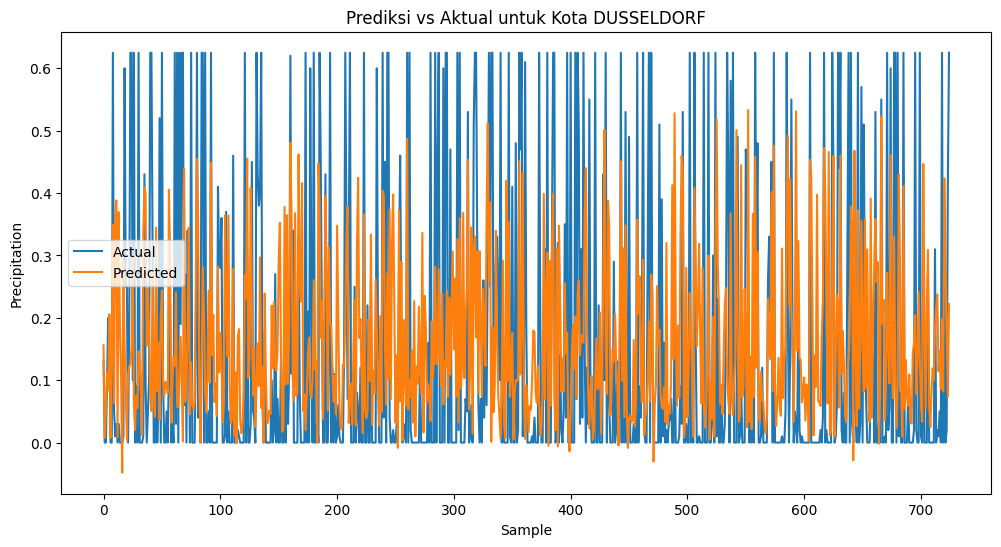

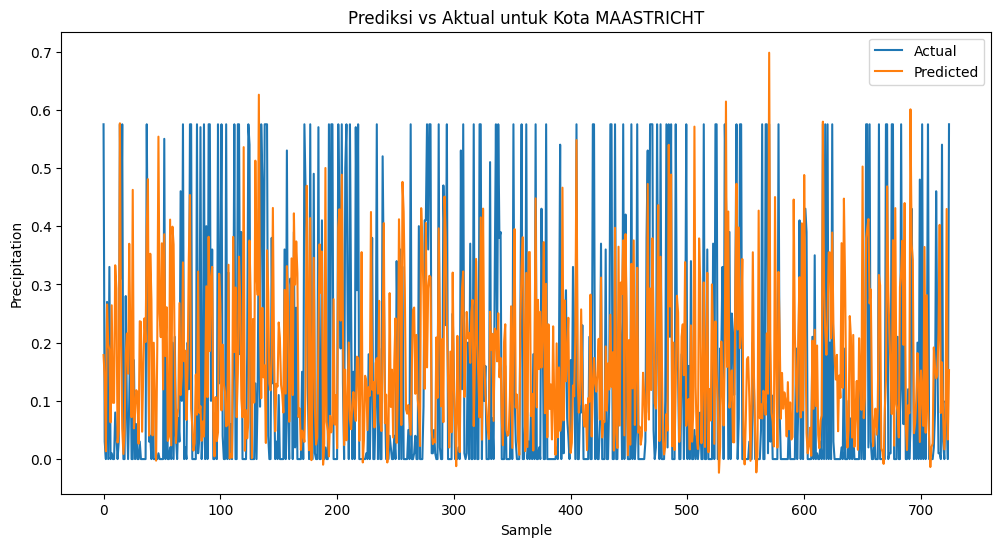

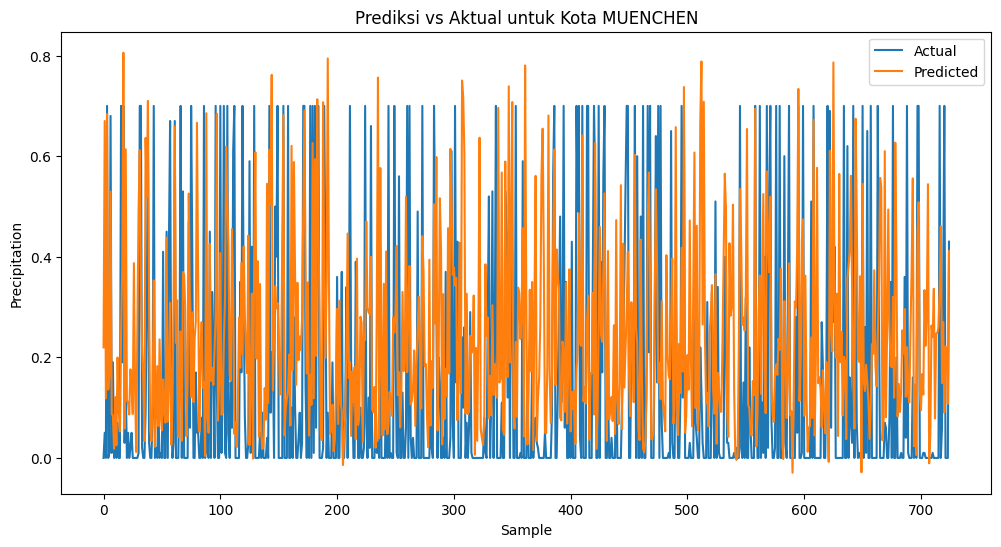

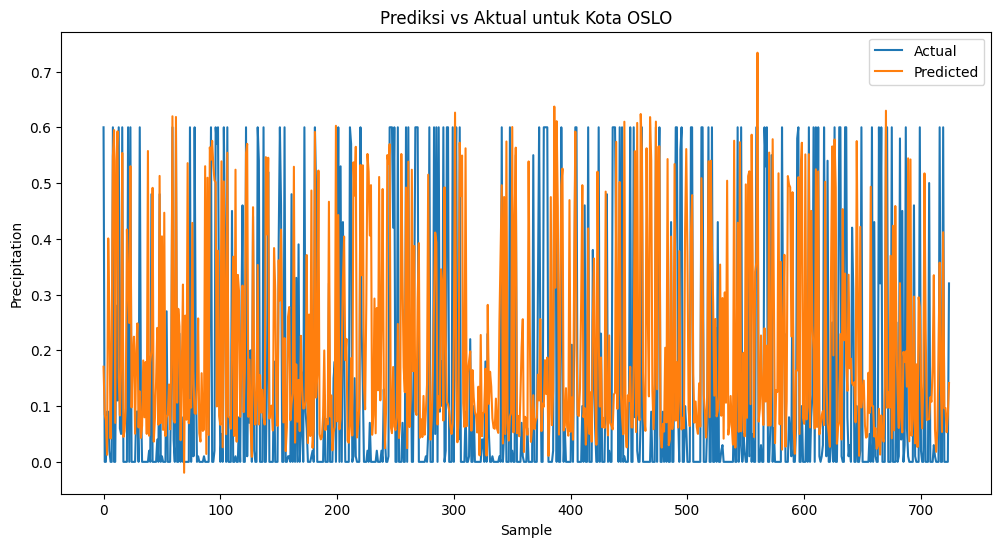

In [102]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_predictions(model, data_loader, kota, scaler, window_size=30):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            preds.extend(y_pred.flatten())
            actuals.extend(y_batch.numpy().flatten())

    # Jika target dinormalisasi, lakukan inverse transformasi ke skala asli
    # Karena kita hanya men-scaler fitur, kita butuh cara khusus jika target juga di-scale
    # Misal, jika target adalah fitur ke-n, lakukan inverse pada kolom target ini saja
    # Kalau tidak, pastikan target y_tensor sudah pada skala asli

    plt.figure(figsize=(12,6))
    plt.plot(actuals, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.title(f'Prediksi vs Aktual untuk Kota {kota.upper()}')
    plt.xlabel('Sample')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.show()

# Contoh pemanggilan visualisasi untuk tiap kota
for kota in kota_list:
    model = data_per_kota[kota]['model'].to(device)
    test_loader = data_per_kota[kota]['test_loader']
    scaler = data_per_kota[kota]['scaler']  # Jika kamu scaling fitur, target mungkin tidak diskalakan

    plot_predictions(model, test_loader, kota, scaler)


In [103]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import torch

# Step 1: Baca file label dan konversi DATE
df_labels = pd.read_csv("weather_prediction_bbq_labels.csv")  # ubah path jika perlu
df_labels['DATE'] = pd.to_datetime(df_labels['DATE'].astype(str), format='%Y%m%d')


In [104]:
label_cols = ['DUSSELDORF_BBQ_weather', 'MAASTRICHT_BBQ_weather', 'MUENCHEN_BBQ_weather', 'OSLO_BBQ_weather']
label_encoder = LabelEncoder()
for col in label_cols:
    df_labels[col] = label_encoder.fit_transform(df_labels[col])

In [105]:
df_labels

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,2000-01-01,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
1,2000-01-02,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
2,2000-01-03,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3,2000-01-04,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
4,2000-01-05,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2009-12-28,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3650,2009-12-29,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3651,2009-12-30,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3652,2009-12-31,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False


In [106]:
# Step 3: Loop tiap kota dan siapkan hasil prediksi LSTM
svm_reports = {}

for kota in ['dusseldorf', 'maastricht', 'muenchen', 'oslo']:
    label_col = f"{kota.upper()}_BBQ_weather"

    # Ambil hasil prediksi dari model LSTM
    model = data_per_kota[kota]['model'].to('cpu')
    X_tensor = data_per_kota[kota]['X_tensor']

    # Ambil tanggal windowed yang sudah disimpan saat preprocessing
    windowed_dates = data_per_kota[kota]['dates']

    # Prediksi temperatur rata-rata
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).squeeze().numpy()

    # Buat DataFrame prediksi
    df_preds = pd.DataFrame({
        'DATE': windowed_dates,
        'predicted_tempmean': preds
    })

    # Gabungkan dengan label BBQ
    print(f"Shape of df_preds for {kota}: {df_preds.shape}")
    print(f"Shape of df_labels for {kota}: {df_labels[['DATE', label_col]].shape}")
    df_merge = df_preds.merge(df_labels[['DATE', label_col]], on='DATE', how='inner')
    print(f"Shape of merged df for {kota}: {df_merge.shape}")

    # Siapkan data untuk SVM
    X = df_merge[['predicted_tempmean']].values
    y = df_merge[label_col].values

    # Split manual: 80% train, 20% test
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Latih SVM dan evaluasi
    clf = SVC(kernel='rbf', C=1.0, gamma='scale')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Simpan hasil evaluasi
    report = classification_report(y_test, y_pred, target_names=['Tidak BBQ', 'BBQ'], output_dict=True)
    svm_reports[kota] = {
        "report": report,
        "y_test": y_test,
        "y_pred": y_pred
    }

# Tampilkan ringkasan hasil
for kota, result in svm_reports.items():
    print(f"\n=== Klasifikasi SVM untuk {kota.upper()} ===")
    print(classification_report(result['y_test'], result['y_pred'], target_names=['Tidak BBQ', 'BBQ']))


Shape of df_preds for dusseldorf: (3624, 2)
Shape of df_labels for dusseldorf: (3654, 2)
Shape of merged df for dusseldorf: (3624, 3)
Shape of df_preds for maastricht: (3624, 2)
Shape of df_labels for maastricht: (3654, 2)
Shape of merged df for maastricht: (3624, 3)


c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Shape of df_preds for muenchen: (3624, 2)
Shape of df_labels for muenchen: (3654, 2)
Shape of merged df for muenchen: (3624, 3)


c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Shape of df_preds for oslo: (3624, 2)
Shape of df_labels for oslo: (3654, 2)
Shape of merged df for oslo: (3624, 3)

=== Klasifikasi SVM untuk DUSSELDORF ===
              precision    recall  f1-score   support

   Tidak BBQ       0.78      0.99      0.88       564
         BBQ       0.57      0.02      0.05       161

    accuracy                           0.78       725
   macro avg       0.68      0.51      0.46       725
weighted avg       0.73      0.78      0.69       725


=== Klasifikasi SVM untuk MAASTRICHT ===
              precision    recall  f1-score   support

   Tidak BBQ       0.79      1.00      0.88       570
         BBQ       0.00      0.00      0.00       155

    accuracy                           0.79       725
   macro avg       0.39      0.50      0.44       725
weighted avg       0.62      0.79      0.69       725


=== Klasifikasi SVM untuk MUENCHEN ===
              precision    recall  f1-score   support

   Tidak BBQ       0.77      1.00      0.87       5

c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Devina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,